In [96]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.mode.chained_assignment = None

# Applied Machine Learning
In this assignment we will explore a dataset about soccer players and referees, focusing predictions and clustering essentially on the players' skin color.

## Preprocessing

Let's have a look at the data:

In [97]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.ix[:5,:14]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0


In [98]:
data.ix[:5,15:]

,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


### NaN values

In [99]:
data.isnull().sum()

playerShort          0
player               0
club                 0
leagueCountry        0
birthday             0
height             263
weight            2243
position         17726
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          21407
rater1           21407
rater2           21407
refNum               0
refCountry           0
Alpha_3              1
meanIAT            163
nIAT               163
seIAT              163
meanExp            163
nExp               163
seExp              163
dtype: int64

In [100]:
filtered = data.dropna()

In [101]:
len(filtered)/len(data)

0.790649738406333

If we would decide to simply discard all the NaN values, we would keep only 21% of the DataSet. We are mainly interested in the skin color of each player so we will have a closer look at the `rater1` and `rater2` skin rating columns.

### Skin Color

In [102]:
len(data[data.rater1.isnull() & (data.rater2.isnull())])/len(data)

0.14659517352836443

15% of the dataset will be discarded as it doesn't give any information about the skin color.

In [103]:
skin_data = data.dropna(how='all', subset=['rater1','rater2'])

In [104]:
len(skin_data[skin_data.rater1.isnull() | (skin_data.rater2.isnull())])

0

We can observe that there were always values for both `rater1` and `rater2` or not any values. Let's have a look at the data for which the raters gave a different skin color.

In [105]:
skin_data_differ = skin_data[skin_data.rater1 != skin_data.rater2]

In [106]:
len(skin_data_differ)/len(skin_data)

0.23195930059941744

For 23% of the player the two raters gave a different value. Let's see if they gave skin colors that are almost the same or opposite skin colors:

In [107]:
skin_data['skin_difference'] = skin_data.apply(lambda x: abs(x['rater1'] - x['rater2']), axis=1)

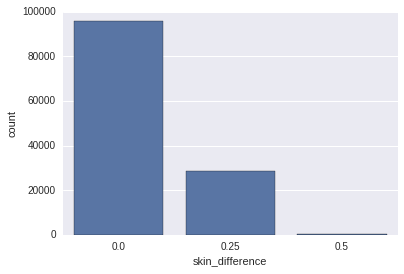

In [108]:
palette = sns.color_palette()
sns.countplot(x="skin_difference", data=skin_data, color=palette[0]);

If the two raters differ, it is only by one on the 5-point scale or by 2. We decide to keep the average value of the two raters on a 0 to 4 scale.

In [109]:
skin_data['skin'] = skin_data.apply(lambda x: round((x['rater1']+x['rater2'])/2*4), axis=1)

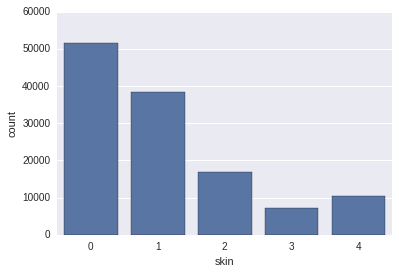

In [110]:
sns.countplot(x="skin", data=skin_data, color=palette[0]);

We can observe that the raters are probably not that accurate as the data is skewed.

### Birthday
There are not any missing birthday value. We will have a look at the distribution.

In [111]:
# The birthday string is converted into a datetime type
import datetime
skin_data['birthday'] = skin_data.apply(lambda x: datetime.datetime.strptime(x['birthday'], "%d.%m.%Y"), axis=1)

In [112]:
skin_data['birthday'].head()

0   1983-08-31
1   1982-01-08
5   1979-11-08
6   1985-11-10
7   1986-04-04
Name: birthday, dtype: datetime64[ns]

In [113]:
# We will plot number of birthdays per month:
birthdays = pd.DataFrame()
birthdays['birthday'] = skin_data.apply(lambda x: (x['birthday'] - np.timedelta64(x['birthday'].day-1,'D')), axis=1)

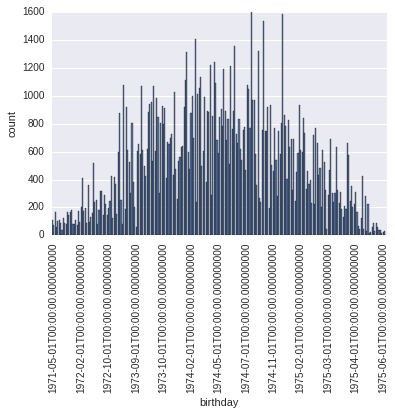

In [114]:
p = sns.countplot(x="birthday", data=birthdays, color=palette[0])
plt.setp(p.get_xticklabels(), rotation=90)
p.set(xticks=np.arange(1,244,20));

Everything seems fine for the date values.

### League Country

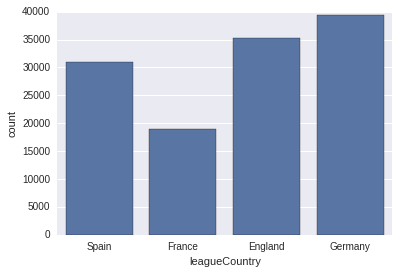

In [115]:
sns.countplot(x="leagueCountry", data=skin_data, color=palette[0]);

### Height

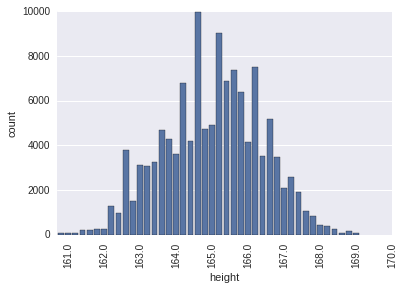

In [116]:
h = sns.countplot(x="height", data=skin_data, color=palette[0])
plt.setp(h.get_xticklabels(), rotation=90)
h.set(xticks=np.arange(1,48,5));

There is no outliers and the distribution looks normal.

### Weight

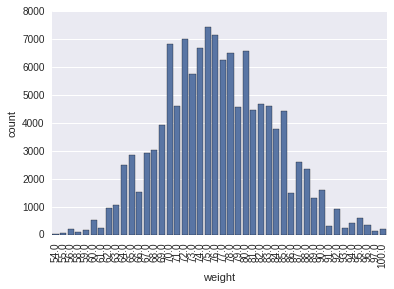

In [117]:
w = sns.countplot(x="weight", data=skin_data, color=palette[0])
plt.setp(w.get_xticklabels(), rotation=90);
#w.set(xticks=np.arange(1,50,5));

### Position 

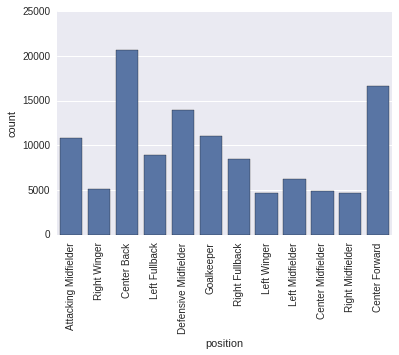

In [118]:
pos = sns.countplot(x="position", data=skin_data, color=palette[0]);
plt.setp(pos.get_xticklabels(), rotation=90);

In [119]:
missing_values = skin_data['position'].isnull().value_counts()

In [120]:
missing_values[1]/missing_values[0]

0.072839187327823685

7% of the positions are missing. We will replace them by the most by a category `Missing Position`.

### Referees

In [121]:
print('There are ' + str(len(skin_data['refNum'].value_counts())) + ' different referees.')

There are 2978 different referees.


In [122]:
print('Which come from ' + str(len(skin_data['refCountry'].value_counts())) + ' different countries...')

Which come from 160 different countries...


### Standardization, Categorical Features Encoding and Replacing Missing Values

We transform each feature into a representation that is more suitable for the machine learning methods. Each feature will be **standardized** if it is a float number (remove mean value, scale dividing by standard deviation) using the `StandardScaler()` function from `sklearn`. If there are missing values, they will be replaced by the mean, which is 0 after applying the StandardScaler. The categorical features will be **encoded** using the `LabelEncoder()` function which converts categorical variable into numerical values. The learning models consider continuous values and don't handle categorical features, but we hope RandomForest will be robust again those values. The missing categorical variables are replaced by `Missing Category`. We discard the name of the player, as well as the photoID and the birthday as it is a one to one relationship with the skin color.

In [123]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, Imputer 
from sklearn.feature_extraction import DictVectorizer

# Replacing missing values for categorical data:
skin_data['position'] = skin_data['position'].fillna('Missing Position')
# For the Alpha_3 there is only one missing value so we will drop it
skin_data = skin_data.dropna(subset=['Alpha_3'])

# Features to be standardized
stand = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'redCards', 'yellowReds', 'meanIAT','seIAT','meanExp','seExp']
# Categorical features to be encoded
cat = ['club', 'leagueCountry', 'position', 'Alpha_3']

# Encode categories
for c in cat:
    skin_data[c] = LabelEncoder().fit_transform(skin_data[c])

# The first function fills the missing values and the second one will apply the standardization 
for s in stand:
    skin_data[s] = Imputer(strategy='mean', axis=1).fit_transform(skin_data[s])[0]
    skin_data[s] = StandardScaler().fit_transform(skin_data[s])
    
# Discard names of players and photoID
skin_data_dropped = skin_data.drop(labels=['playerShort','player', 'photoID','birthday'], axis=1)

In [124]:
skin_data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_difference,skin
0,lucas-wilchez,Lucas Wilchez,70,3,1983-08-31,-0.753342,-0.609486,0,-0.556813,-0.714223,...,1,60,-0.677683,712.0,-0.013506,-0.309476,750.0,-0.014768,0.25,2
1,john-utaka,John Utaka,51,1,1982-01-08,-0.459377,0.785829,12,-0.556813,-0.714223,...,2,157,-4.513948,40.0,2.140990,-3.048676,49.0,2.969357,0.00,3
5,aaron-hughes,Aaron Hughes,34,0,1979-11-08,-0.018431,-0.749017,1,-0.556813,-0.714223,...,4,88,-0.715302,127.0,0.557507,0.340820,130.0,0.546239,0.25,0
6,aleksandar-kolarov,Aleksandar Kolarov,48,0,1985-11-10,0.716480,0.506766,6,-0.556813,-0.182282,...,4,88,-0.715302,127.0,0.557507,0.340820,130.0,0.546239,0.25,0
7,alexander-tettey,Alexander Tettey,54,0,1986-04-04,-0.312395,-1.167612,4,-0.556813,-0.714223,...,4,88,-0.715302,127.0,0.557507,0.340820,130.0,0.546239,0.00,4


# 1. Random Forest Skin Color Classifier

The most important parameters that can affect the accuracy of the random forest classifier are the number of trees in the forest `n_estimators`, the number of features to consider when looking for a best split `max_features`, the maximum depth of the tree `max_depth` and the minimum number of samples required to be at a leaf node `min_samples_leaf`. There are other parameters but we will have a closer look at those ones.

We seperate the data between the features used for prediction and the target features (skin). We need to drop the `rater1`, `rater2`, `skin` and `skin_difference` values as we want to predict the `skin`.

In [125]:
to_predict = ['rater1', 'rater2', 'skin', 'skin_difference']
data = skin_data_dropped.drop(labels=to_predict, axis=1)
features = data.columns
# Skin to predict
target = skin_data_dropped['skin'].values.ravel()

First, all the columns will be used to train the Random Forest Classifier.

### n_estimators
We will test the accuracy of the model for different number of trees. We use 5-folds cross validation to measure the accuracy of the predictive model, we use the mean of the accuracy over the 5 folds to tune the parameters.

In [31]:
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

In [32]:
number_trees = [5,10,20,50,100,200]
accuracy = []

for t in number_trees:
    tree = RandomForestClassifier(n_estimators=t)
    scores = cross_validation.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

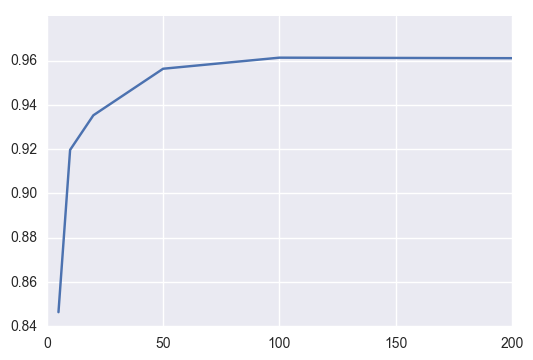

In [33]:
plt.plot(number_trees, accuracy);

Higher number of trees will avoid overfitting (because the model takes the maximum voting of predictions) and give more stable predictions but it makes the code run slower. We decide to keep 100 trees.

### max_features
As default, the number of features to consider when looking for the best split is equal to the square root of the number of features. We will test it with different values between 1 and the number of features.

In [34]:
max_features = range(1,len(features)+1,2)
accuracy = []

for m in max_features:
    tree = RandomForestClassifier(n_estimators=100, max_features=m)
    scores = cross_validation.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

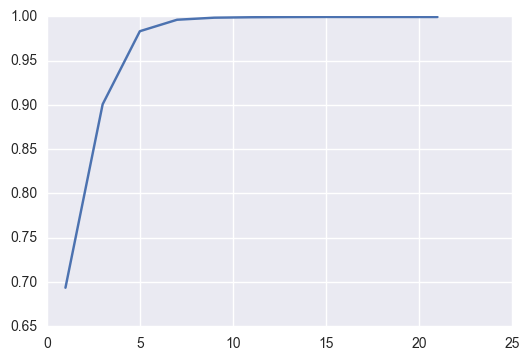

In [36]:
plt.plot(max_features, accuracy);

Increasing max_features improves the performance of the model (at each node now we have a higher number of options). However it increases the speed of algorithm. We choose to take `max_features`=5.



### max_depth
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure.

In [37]:
max_depths = [1,5,10,50]
accuracy = []

for d in max_depths:
    tree = RandomForestClassifier(n_estimators=100, max_features=5, max_depth=d)
    scores = cross_validation.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

In [38]:
#We compute as well with the default value
tree = RandomForestClassifier(n_estimators=100, max_features=5, max_depth=None)
scores = cross_validation.cross_val_score(tree, data, target, cv=5)
accuracy.append(scores.mean())

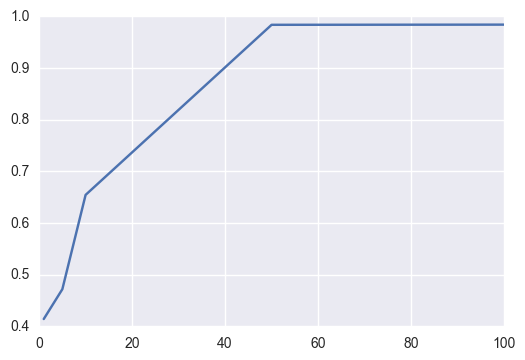

In [39]:
max_depths.append(100) # it will simple represent the default value
plt.plot(max_depths, accuracy);

In our case, there is no overfitting problem with a tree having pure nodes. We will keep the default value.

### min_samples_leaf
The minimum number of samples required to be at a leaf node (we will give it in percentage)

In [40]:
min_samples = [0.01,0.02,0.05,0.1]
accuracy = []

for s in min_samples:
    tree = RandomForestClassifier(n_estimators=100, max_features=5, min_samples_leaf=s)
    scores = cross_validation.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

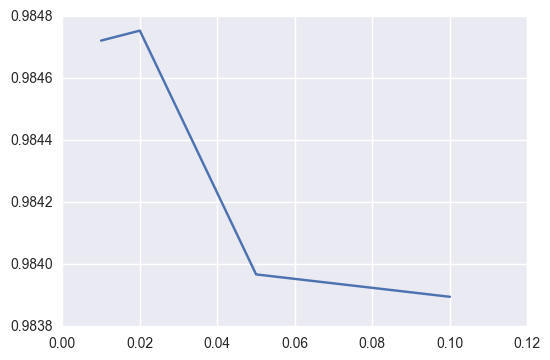

In [41]:
plt.plot(min_samples, accuracy);

If less than 0.02% are in a leaf the model is overfitting and if more than 0.02% are in a leaf node it is underfitting.

### feature\_importances\_
Now we will have a look at the feature sorted by their score in the tree with the tuned parameter we found.

In [42]:
tree = RandomForestClassifier(n_estimators=100, max_features=5).fit(data, target)

In [43]:
sorted(zip(map(lambda x: round(x, 4), tree.feature_importances_), features), reverse=True)

[(0.21249999999999999, 'weight'),
 (0.21060000000000001, 'club'),
 (0.2029, 'height'),
 (0.15210000000000001, 'position'),
 (0.040399999999999998, 'leagueCountry'),
 (0.0292, 'refNum'),
 (0.0178, 'games'),
 (0.0154, 'victories'),
 (0.0121, 'defeats'),
 (0.0111, 'meanExp'),
 (0.010999999999999999, 'goals'),
 (0.0103, 'refCountry'),
 (0.0101, 'ties'),
 (0.0095999999999999992, 'yellowCards'),
 (0.0094999999999999998, 'Alpha_3'),
 (0.0094000000000000004, 'meanIAT'),
 (0.0091999999999999998, 'seIAT'),
 (0.0086999999999999994, 'nIAT'),
 (0.0085000000000000006, 'seExp'),
 (0.0082000000000000007, 'nExp'),
 (0.00089999999999999998, 'redCards'),
 (0.00080000000000000004, 'yellowReds')]

The `weight`, `club`, `height`, `position` and `leagueCountry` features are the ones adding the more information about the skin color. 

We will try to train the tree only with those features to see if their importance order changes.

In [44]:
reduced_features = ['club','height','weight','position', 'leagueCountry']
tree = RandomForestClassifier(n_estimators=100, max_features=5).fit(data[reduced_features], target)

In [45]:
sorted(zip(map(lambda x: round(x, 4), tree.feature_importances_), features), reverse=True)

[(0.27829999999999999, 'leagueCountry'),
 (0.27179999999999999, 'height'),
 (0.24340000000000001, 'club'),
 (0.18010000000000001, 'weight'),
 (0.0264, 'position')]

It is interesting to see that the order of the features changes, the `leagueCountry` is now the feature adding the most information about the skin color even if it was in the last position in the previous tree classifier. 

# 2. Clustering

In [128]:
grouped = skin_data.groupby('playerShort')

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'skin_difference', 'skin', 'weightMeanIAT',
       'weightMeanExp'],
      dtype='object')

- Weighted mean for the two mean scores. 
- for stderr measures first square to get variance, then compute mean of variances, then squareroot to get stderr again. 

In [129]:
skin_data['weightMeanIAT'] = skin_data.meanIAT * skin_data.nIAT / skin_data.nIAT.sum()
skin_data['weightMeanExp'] = skin_data.meanExp * skin_data.nExp / skin_data.nExp.sum()
unique_count = lambda df: len(df.unique())
agg_stderr = lambda df: math.sqrt(np.mean(df**2))

`nIAT` and `nExp` probably aren't necessary anymore

In [131]:
f = {'redCards': ['mean', 'sum'], 'yellowCards': ['mean', 'sum'], 'yellowReds': ['mean', 'sum'],
     'refNum': unique_count, 'refCountry': unique_count, 'meanIAT': 'mean', 'meanExp': 'mean', 'seIAT': agg_stderr,
    'seExp': agg_stderr, 'nIAT': 'sum', 'nExp': 'sum'}

agg_grouped = grouped.agg(f)

In [132]:
agg_grouped

meanIAT       nIAT yellowCards             redCards  \
                            mean        sum        mean        sum      mean   
playerShort                                                                    
aaron-hughes           -0.051875  3271886.0   -0.346517 -57.521792 -0.111946   
aaron-hunt              0.021697  2584325.0    0.030510   3.020536 -0.023264   
aaron-lennon           -0.069532  2144721.0   -0.353268 -35.680047 -0.111946   
aaron-ramsey           -0.040581  3981726.0   -0.123041 -12.796250 -0.027527   
abdelhamid-el-kaoutari -0.515270   104797.0   -0.222670  -8.238808  0.362626   
abdou-traore_2         -0.874543   189994.0   -0.167065  -7.016715 -0.111946   
abdoulaye-diallo_2     -0.202627    52934.0   -0.485819  -9.716384 -0.111946   
abdoulaye-keita_2       0.227117     3456.0   -0.485819  -0.971638 -0.111946   
abdoulwhaid-sissoko     0.001736   138331.0   -0.029421  -1.647556  0.201610   
abdul-rahman-baba      -0.188673   184400.0   -0.350590  -9.465930  0.213223   
abdul-razak             0.200928   840540.0   -0.412058 -13.597908 -0.111946   
abel-aguilar            0.344926  2319585.0    0.288675  31.754282  0.047682   
abelaziz-barrada       -0.205236    84581.0   -0.142545  -5.559258  0.113171   
abou-diaby             -0.349774  1273170.0   -0.036442  -2.368741  0.158195   
adam-bodzek            -0.358453   433944.0    0.948576  53.120267 -0.111946   
adam-campbell          -0.463920   550269.0   -0.414227  -7.041863 -0.111946   
adam-federici          -0.557351  7146937.0   -0.425717 -34.483103 -0.111946   
adam-hlousek            0.519203   328608.0   -0.059847  -3.590833 -0.111946   
adam-johnson           -0.290535  2654381.0   -0.208011 -19.137047 -0.111946   
adam-morgan            -0.035097   598408.0   -0.485819 -11.173841 -0.111946   
adam-pinter             0.539319   235958.0   -0.181553 -10.166996  0.044832   
adam-smith_3           -0.517473  2658363.0    0.018393   1.287477  0.013476   
adam-szalai            -0.010336   450957.0   -0.172860 -12.100213 -0.111946   
adan                    0.656810   105304.0   -0.446559 -13.843332  0.171266   
adel-taarabt           -0.674983  2809079.0   -0.152576 -12.816368 -0.111946   
adil-rami               0.200082   505782.0    0.225138  22.738965  0.148833   
adrian-colunga          0.547488    87911.0    0.083870   3.941879 -0.111946   
adrian-mutu             0.499829  1198464.0    0.198779  31.804578  0.052671   
adrian_2                0.278337  2565503.0   -0.259389 -22.307446 -0.111946   
adrian_7                0.678926    49980.0   -0.355420  -9.951749 -0.111946   
...                          ...        ...         ...        ...       ...   
xisco_2                 0.425871   485456.0   -0.046324  -3.335350 -0.111946   
yacine-brahimi         -0.143506   159389.0   -0.138087  -9.666088 -0.111946   
yann-mvila              0.313882   560207.0   -0.075414  -6.485630 -0.009858   
yannick-djalo           0.486250  6297333.0   -0.329785 -25.723269 -0.111946   
yannik-schulze         -0.358453   271215.0   -0.207633  -7.267169 -0.111946   
yassine-benzia         -0.325916  2097808.0   -0.287693 -12.370786 -0.111946   
yassine-el-ghanassi     0.372101   408184.0   -0.213342 -14.293944 -0.111946   
yassine-jebbour        -0.146004    92765.0   -0.404682 -12.140450  0.473359   
yaya-toure             -0.054684  1189535.0    0.170754  25.954630 -0.054186   
yoan-gouffran          -0.289037   919219.0   -0.193724 -14.529309  0.005115   
yoann-gourcuff          0.058532  2569892.0   -0.171411 -20.569357  0.034380   
yohan-cabaye           -0.087488  1320231.0    0.393739  46.854914 -0.038168   
yohandry-orozco         0.848965  2043746.0   -0.379988 -17.479431 -0.111946   
yossi-benayoun          0.158130  4177246.0   -0.229160 -33.686475 -0.111946   
younes-belhanda         0.017749   151010.0    0.122712   7.853580  0.299597   
younes-kaboul          -0.148622  1277976.0   -0.136089 -11.839700  0.089883   
youssef-el-arabi       -0